In [1]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from utils import *


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [9]:
source_path = "../Data/Augmentation/Tomato"
training_path = "../train_data/Tomato"
testing_path = "../test_data/Tomato"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Late_blight
[Training Samples:1336, Testing Samples:573]   Original Samples:1909
---------------------
Finish splitting Septoria_leaf_spot
[Training Samples:1240, Testing Samples:531]   Original Samples:1771
---------------------
Finish splitting Tomato_Yellow_Leaf_Curl_Virus
[Training Samples:3750, Testing Samples:1607]   Original Samples:5357
---------------------
Finish splitting Healthy
[Training Samples:1114, Testing Samples:477]   Original Samples:1591
---------------------
Finish splitting Early_blight
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Target_Spot
[Training Samples:983, Testing Samples:421]   Original Samples:1404
---------------------
Finish splitting Leaf_Mold
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Tomato_m

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


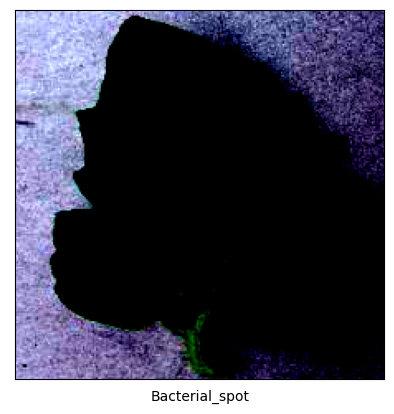

In [10]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [11]:
batch_size = 4
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 11188
Length of Validation Data : 2797


### EfficientB0 Model

In [12]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(efficient_model, "../Models/tomato_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8611 | train_acc: 0.7241 | train_f1: 0.7241 | val_loss: 1.7326 | val_acc: 0.8664 | val_f1: 0.8663 | 
Epoch: 2 | train_loss: 0.6052 | train_acc: 0.8024 | train_f1: 0.8024 | val_loss: 3.7360 | val_acc: 0.8764 | val_f1: 0.8763 | 
Epoch: 3 | train_loss: 0.5634 | train_acc: 0.8110 | train_f1: 0.8110 | val_loss: 5.0286 | val_acc: 0.8771 | val_f1: 0.8770 | 
Epoch: 4 | train_loss: 0.5511 | train_acc: 0.8189 | train_f1: 0.8189 | val_loss: 6.7603 | val_acc: 0.8732 | val_f1: 0.8731 | 
Epoch: 5 | train_loss: 0.5509 | train_acc: 0.8199 | train_f1: 0.8199 | val_loss: 6.9527 | val_acc: 0.8775 | val_f1: 0.8774 | 
Epoch: 6 | train_loss: 0.5613 | train_acc: 0.8167 | train_f1: 0.8167 | val_loss: 10.6837 | val_acc: 0.8896 | val_f1: 0.8895 | 
Epoch: 7 | train_loss: 0.5272 | train_acc: 0.8257 | train_f1: 0.8257 | val_loss: 4.4567 | val_acc: 0.8779 | val_f1: 0.8777 | 
Epoch: 8 | train_loss: 0.5325 | train_acc: 0.8271 | train_f1: 0.8271 | val_loss: 1.7582 | val_acc: 0.8804 | val_f1: 0

In [13]:
# accuracy for efficientNet b0
efficient_model = torch.load("../Models/tomato_efficient_model.pt")
test_run(efficient_model, test_dl, device, batch_size, classes)

Test accuracy: 86.351%
Test F1 Score: 0.864
Acc for Class Bacterial_spot = 92.163%
Acc for Class Early_blight = 66.000%
Acc for Class Healthy = 98.323%
Acc for Class Late_blight = 82.373%
Acc for Class Leaf_Mold = 85.333%
Acc for Class No_leaves = 93.003%
Acc for Class Septoria_leaf_spot = 90.584%
Acc for Class Spider_mites Two-spotted_spider_mite = 89.264%
Acc for Class Target_Spot = 79.572%
Acc for Class Tomato_Yellow_Leaf_Curl_Virus = 81.581%
Acc for Class Tomato_mosaic_virus = 99.000%


### MobileNetV2 Model

In [14]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(mobile_model, "../Models/tomato_mobile_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9454 | train_acc: 0.7066 | train_f1: 0.7066 | val_loss: 0.3960 | val_acc: 0.8882 | val_f1: 0.8881 | 
Epoch: 2 | train_loss: 0.6633 | train_acc: 0.7834 | train_f1: 0.7834 | val_loss: 0.3339 | val_acc: 0.9018 | val_f1: 0.9017 | 
Epoch: 3 | train_loss: 0.6299 | train_acc: 0.7956 | train_f1: 0.7956 | val_loss: 0.3071 | val_acc: 0.9043 | val_f1: 0.9042 | 
Epoch: 4 | train_loss: 0.5724 | train_acc: 0.8131 | train_f1: 0.8131 | val_loss: 0.2739 | val_acc: 0.9175 | val_f1: 0.9174 | 
Epoch: 5 | train_loss: 0.5704 | train_acc: 0.8113 | train_f1: 0.8113 | val_loss: 0.2585 | val_acc: 0.9200 | val_f1: 0.9199 | 
Epoch: 6 | train_loss: 0.5616 | train_acc: 0.8178 | train_f1: 0.8178 | val_loss: 0.2577 | val_acc: 0.9218 | val_f1: 0.9217 | 
Epoch: 7 | train_loss: 0.5500 | train_acc: 0.8183 | train_f1: 0.8183 | val_loss: 0.2437 | val_acc: 0.9246 | val_f1: 0.9246 | 
Epoch: 8 | train_loss: 0.5514 | train_acc: 0.8182 | train_f1: 0.8182 | val_loss: 0.2443 | val_acc: 0.9261 | val_f1: 0.

In [17]:
# MobileNet V2 accuracy
mobile_model = torch.load("../Models/tomato_mobile_model.pt")
test_run(mobile_model, test_dl, device, batch_size, classes)

Test accuracy: 91.640%
Test F1 Score: 0.916
Acc for Class Bacterial_spot = 92.476%
Acc for Class Early_blight = 63.667%
Acc for Class Healthy = 99.161%
Acc for Class Late_blight = 90.401%
Acc for Class Leaf_Mold = 92.000%
Acc for Class No_leaves = 99.708%
Acc for Class Septoria_leaf_spot = 90.395%
Acc for Class Spider_mites Two-spotted_spider_mite = 85.885%
Acc for Class Target_Spot = 86.461%
Acc for Class Tomato_Yellow_Leaf_Curl_Virus = 95.706%
Acc for Class Tomato_mosaic_virus = 96.000%


### Predicting Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


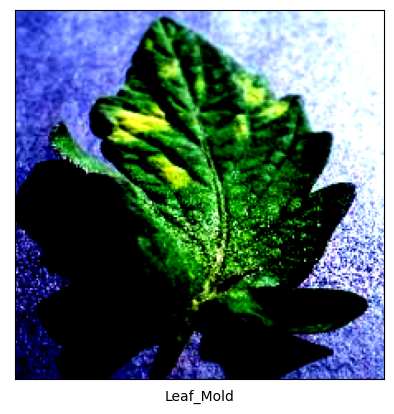

In [18]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/test_data/Tomato/Leaf_Mold/image (127).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)